# DeepLOB: Deep Convolutional Neural Networks for Limit Order Books

### Authors: Zihao Zhang, Stefan Zohren and Stephen Roberts
Oxford-Man Institute of Quantitative Finance, Department of Engineering Science, University of Oxford

This jupyter notebook is used to demonstrate our recent paper [2] published in IEEE Transactions on Singal Processing. We use FI-2010 [1] dataset and present how model architecture is constructed here.

### Data:
The FI-2010 is publicly avilable and interested readers can check out their paper [1]. The dataset can be downloaded from: https://etsin.fairdata.fi/dataset/73eb48d7-4dbc-4a10-a52a-da745b47a649

Otherwise, the notebook will download the data automatically or it can be obtained from:

https://drive.google.com/drive/folders/1Xen3aRid9ZZhFqJRgEMyETNazk02cNmv?usp=sharing

### References:
[1] Ntakaris A, Magris M, Kanniainen J, Gabbouj M, Iosifidis A. Benchmark dataset for mid‐price forecasting of limit order book data with machine learning methods. Journal of Forecasting. 2018 Dec;37(8):852-66. https://arxiv.org/abs/1705.03233

[2] Zhang Z, Zohren S, Roberts S. DeepLOB: Deep convolutional neural networks for limit order books. IEEE Transactions on Signal Processing. 2019 Mar 25;67(11):3001-12. https://arxiv.org/abs/1808.03668

### This notebook runs on Pytorch 1.9.0.

In [ ]:
!gdown https://drive.google.com/uc?id=1J3bAEn7F17Da5OLxhD-9c2M_z2YPUaCo

Downloading...
From (original): https://drive.google.com/uc?id=1J3bAEn7F17Da5OLxhD-9c2M_z2YPUaCo
From (redirected): https://drive.google.com/uc?id=1J3bAEn7F17Da5OLxhD-9c2M_z2YPUaCo&confirm=t&uuid=870910e9-455d-4834-8d06-764752544671
To: /content/01_05_2024_BTCUSDT_0100ms_300k.zip
100% 108M/108M [00:00<00:00, 175MB/s]


In [ ]:
#06-07-2024
!gdown https://drive.google.com/uc?id=1-7fMwrOURKnDoVeZFgRD8sD3YvsYGItn #https://drive.google.com/uc?id=1-Gm76n-6d3hixPj6-lWSeijlyxSu5fWV
#11-13-2023
!gdown https://drive.google.com/uc?id=1-JpxHhXzxH0gRP81ho1ZPwq7CpgM6rsI
#01-05-2024
!gdown https://drive.google.com/uc?id=1-7A84Vq5wKWr8BPZL18oh2T4WTeNb_Fr #1-LLJl0ScXZWad9VN6_5yXfeRDw749CKj

Downloading...
From: https://drive.google.com/uc?id=1-7fMwrOURKnDoVeZFgRD8sD3YvsYGItn
To: /content/06-07_2024_BTCUSDT_1min.zip
100% 25.8M/25.8M [00:00<00:00, 41.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1-JpxHhXzxH0gRP81ho1ZPwq7CpgM6rsI
From (redirected): https://drive.google.com/uc?id=1-JpxHhXzxH0gRP81ho1ZPwq7CpgM6rsI&confirm=t&uuid=9c1065b9-621a-4851-ab96-e7db85549143
To: /content/11-12_2023_BTCUSDT_1min.zip
100% 238M/238M [00:02<00:00, 106MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1-7A84Vq5wKWr8BPZL18oh2T4WTeNb_Fr
From (redirected): https://drive.google.com/uc?id=1-7A84Vq5wKWr8BPZL18oh2T4WTeNb_Fr&confirm=t&uuid=679237f3-1004-4800-82a4-59d2d905b0a8
To: /content/01-05_2023_BTCUSDT_1min.zip
100% 92.5M/92.5M [00:02<00:00, 46.1MB/s]


In [ ]:
!unzip /content/01_05_2024_BTCUSDT_0100ms_300k.zip -d /content

Archive:  /content/01_05_2024_BTCUSDT_0100ms_300k.zip
   creating: /content/content/01.05.2024/
  inflating: /content/content/01.05.2024/01_05_2024_BTCUSDT_0100ms_300k_LBLS.npy  
   creating: /content/content/01.05.2024/.ipynb_checkpoints/
  inflating: /content/content/01.05.2024/01_05_2024_BTCUSDT_0100ms_300k_DATA.npy  
  inflating: /content/content/01.05.2024/01_05_2024_BTCUSDT_0100ms_300k_MID_PRICES.npy  


In [ ]:
!mkdir /content/Train
!mkdir /content/Test

!unzip /content/06_07_2024_BTCUSDT_1min.zip -d /content/Test #if cannot open just create new cell with this line an run it...
!unzip /content/11-12_2023_BTCUSDT_1min.zip -d /content/Test
!unzip /content/01-05_2024_BTCUSDT_1min.zip -d /content/Train

In [ ]:
!pip install torchinfo

In [ ]:
# load packages
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

from torch.utils.data import Dataset, DataLoader, TensorDataset

import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.33)
# N, D = X_train.shape

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Data preparation

We used no auction dataset that is normalised by decimal precision approach in their work. The first seven days are training data and the last three days are testing data. A validation set (20%) from the training set is used to monitor the overfitting behaviours.  

The first 40 columns of the FI-2010 dataset are 10 levels ask and bid information for a limit order book and we only use these 40 features in our network. The last 5 columns of the FI-2010 dataset are the labels with different prediction horizons.

In [ ]:
data=np.expand_dims(np.load('/content/content/01.05.2024/01_05_2024_BTCUSDT_0100ms_300k_DATA.npy'), axis=1)
lbls=np.load('/content/content/01.05.2024/01_05_2024_BTCUSDT_0100ms_300k_LBLS.npy')
data.shape, lbls.shape

((300566, 1, 100, 40), (300560,))

In [ ]:
train_data, val_data=data[:int(data.shape[0] * 0.7),:,:,:], data[int(data.shape[0] * 0.7):,:,:,:]
train_lbls, val_lbls = lbls[:int(lbls.shape[0] * 0.7)], lbls[int(lbls.shape[0] * 0.7):]
train_data.shape, train_lbls.shape, val_data.shape, val_lbls.shape

((210396, 1, 100, 40), (210392,), (90170, 1, 100, 40), (90168,))

In [ ]:
val_data=np.expand_dims(np.load('/content/Test/content/2024/06-07_2024_BTCUSDT_1m_DATA.npy'), axis=1)
val_lbls=np.load('/content/Test/content/2024/06-07_2024_BTCUSDT_1m_LBLS.npy')
train_data=np.expand_dims(np.load('/content/Train/content/2024/01-05_2024_BTCUSDT_1m_DATA.npy'), axis=1)
train_lbls=np.load('/content/Train/content/2024/01-05_2024_BTCUSDT_1m_LBLS.npy')
val_data[:val_lbls.shape[0]].shape, val_lbls.shape

In [ ]:
"""
train_data=train_data[:train_lbls.shape[0]]
train_data=train_data[:int(train_data.shape[0] * 0.8),:,:,:]
train_lbls=train_lbls[:int(train_lbls.shape[0] * 0.8)]
val_data=train_data[int(train_data.shape[0] * 0.8):,:,:,:]
val_lbls=train_lbls[int(train_lbls.shape[0] * 0.8):]
train_data.shape, train_lbls.shape, val_data.shape, val_lbls.shape
"""

In [ ]:
batch_size=64

train_loader=DataLoader(TensorDataset(torch.tensor(train_data[:train_lbls.shape[0]], dtype=torch.float32),
                                      torch.tensor(train_lbls, dtype=torch.float32)),
                                      shuffle=True, batch_size=batch_size, drop_last=True)
val_loader=DataLoader(TensorDataset(torch.tensor(val_data[:val_lbls.shape[0]],dtype=torch.float32),
                                    torch.tensor(val_lbls, dtype=torch.float32)),
                                    batch_size=batch_size, shuffle=False) #drop_last=True)

In [ ]:
x,y=next(iter(val_loader))
x.shape, y.shape

(torch.Size([64, 1, 100, 40]), torch.Size([64]))

# Model Architecture

Please find the detailed discussion of our model architecture in our paper.

In [ ]:
class deeplob(nn.Module):
    def __init__(self, y_len):
        super().__init__()
        self.y_len = y_len

        # convolution blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
#             nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )

        # inception moduels
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )

        # lstm layers
        self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, self.y_len)

    def forward(self, x):
        # h0: (number of hidden layers, batch size, hidden size)
        h0 = torch.zeros(1, x.size(0), 64).to(device)
        c0 = torch.zeros(1, x.size(0), 64).to(device)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)

        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)

#         x = torch.transpose(x, 1, 2)
        x = x.permute(0, 2, 1, 3)
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))

        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc1(x)
        forecast_y = torch.softmax(x, dim=1)

        return forecast_y

In [ ]:
model = deeplob(y_len = 3)
model.to(device)

deeplob(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): Tanh()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): Tanh()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride

In [ ]:
summary(model, (1, 1, 100, 40))

Layer (type:depth-idx)                   Output Shape              Param #
deeplob                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 32, 94, 20]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 20]          96
│    └─LeakyReLU: 2-2                    [1, 32, 100, 20]          --
│    └─BatchNorm2d: 2-3                  [1, 32, 100, 20]          64
│    └─Conv2d: 2-4                       [1, 32, 97, 20]           4,128
│    └─LeakyReLU: 2-5                    [1, 32, 97, 20]           --
│    └─BatchNorm2d: 2-6                  [1, 32, 97, 20]           64
│    └─Conv2d: 2-7                       [1, 32, 94, 20]           4,128
│    └─LeakyReLU: 2-8                    [1, 32, 94, 20]           --
│    └─BatchNorm2d: 2-9                  [1, 32, 94, 20]           64
├─Sequential: 1-2                        [1, 32, 88, 10]           --
│    └─Conv2d: 2-10                      [1, 32, 94, 10]           2,080
│    └

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Model Training


In [ ]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):

    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0

    for it in tqdm(range(epochs)):

        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            # print("inputs.shape:", inputs.shape)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            # print("about to get model output")
            outputs = model(inputs)
            # print("done getting model output")
            # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
            loss = criterion(outputs, targets)
            # Backward and optimize
            # print("about to optimize")
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading

        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        if test_loss < best_test_loss:
            torch.save(model, './best_val_model_pytorch')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')

    return train_losses, test_losses

In [ ]:
train_losses, val_losses = batch_gd(model, criterion, optimizer,
                                    train_loader, val_loader, epochs=50)

  2%|▏         | 1/50 [01:29<1:13:15, 89.70s/it]

model saved
Epoch 1/50, Train Loss: 0.9938,           Validation Loss: 1.0305, Duration: 0:01:29.697616, Best Val Epoch: 0


  4%|▍         | 2/50 [03:00<1:12:30, 90.64s/it]

model saved
Epoch 2/50, Train Loss: 0.9403,           Validation Loss: 1.0264, Duration: 0:01:31.295041, Best Val Epoch: 1


  6%|▌         | 3/50 [04:32<1:11:14, 90.95s/it]

Epoch 3/50, Train Loss: 0.9254,           Validation Loss: 1.0291, Duration: 0:01:31.312371, Best Val Epoch: 1


  8%|▊         | 4/50 [06:03<1:09:50, 91.11s/it]

Epoch 4/50, Train Loss: 0.9132,           Validation Loss: 1.0437, Duration: 0:01:31.354488, Best Val Epoch: 1


 10%|█         | 5/50 [07:34<1:08:22, 91.17s/it]

Epoch 5/50, Train Loss: 0.9014,           Validation Loss: 1.0347, Duration: 0:01:31.288452, Best Val Epoch: 1


 12%|█▏        | 6/50 [09:06<1:06:54, 91.25s/it]

Epoch 6/50, Train Loss: 0.8903,           Validation Loss: 1.0376, Duration: 0:01:31.383442, Best Val Epoch: 1


 14%|█▍        | 7/50 [10:37<1:05:26, 91.31s/it]

Epoch 7/50, Train Loss: 0.8806,           Validation Loss: 1.0485, Duration: 0:01:31.436262, Best Val Epoch: 1


 16%|█▌        | 8/50 [12:09<1:03:56, 91.34s/it]

Epoch 8/50, Train Loss: 0.8714,           Validation Loss: 1.0602, Duration: 0:01:31.409285, Best Val Epoch: 1


 18%|█▊        | 9/50 [13:40<1:02:24, 91.34s/it]

Epoch 9/50, Train Loss: 0.8630,           Validation Loss: 1.0603, Duration: 0:01:31.332957, Best Val Epoch: 1


 20%|██        | 10/50 [15:11<1:00:55, 91.38s/it]

Epoch 10/50, Train Loss: 0.8550,           Validation Loss: 1.0577, Duration: 0:01:31.457384, Best Val Epoch: 1


 22%|██▏       | 11/50 [16:43<59:24, 91.39s/it]  

Epoch 11/50, Train Loss: 0.8488,           Validation Loss: 1.0616, Duration: 0:01:31.406750, Best Val Epoch: 1


 24%|██▍       | 12/50 [18:14<57:52, 91.38s/it]

Epoch 12/50, Train Loss: 0.8419,           Validation Loss: 1.0599, Duration: 0:01:31.362625, Best Val Epoch: 1


 26%|██▌       | 13/50 [19:46<56:19, 91.34s/it]

Epoch 13/50, Train Loss: 0.8358,           Validation Loss: 1.0843, Duration: 0:01:31.253586, Best Val Epoch: 1


 28%|██▊       | 14/50 [21:17<54:48, 91.36s/it]

Epoch 14/50, Train Loss: 0.8302,           Validation Loss: 1.0748, Duration: 0:01:31.385989, Best Val Epoch: 1


 30%|███       | 15/50 [22:48<53:17, 91.37s/it]

Epoch 15/50, Train Loss: 0.8260,           Validation Loss: 1.0721, Duration: 0:01:31.395961, Best Val Epoch: 1


 32%|███▏      | 16/50 [24:20<51:47, 91.39s/it]

Epoch 16/50, Train Loss: 0.8213,           Validation Loss: 1.1461, Duration: 0:01:31.442278, Best Val Epoch: 1


 34%|███▍      | 17/50 [25:51<50:16, 91.40s/it]

Epoch 17/50, Train Loss: 0.8158,           Validation Loss: 1.1204, Duration: 0:01:31.404361, Best Val Epoch: 1


 36%|███▌      | 18/50 [27:23<48:45, 91.41s/it]

Epoch 18/50, Train Loss: 0.8119,           Validation Loss: 1.1071, Duration: 0:01:31.437002, Best Val Epoch: 1


 38%|███▊      | 19/50 [28:54<47:12, 91.36s/it]

Epoch 19/50, Train Loss: 0.8078,           Validation Loss: 1.0961, Duration: 0:01:31.238415, Best Val Epoch: 1


 40%|████      | 20/50 [30:25<45:39, 91.30s/it]

Epoch 20/50, Train Loss: 0.8048,           Validation Loss: 1.0625, Duration: 0:01:31.165933, Best Val Epoch: 1


 42%|████▏     | 21/50 [31:56<44:08, 91.32s/it]

Epoch 21/50, Train Loss: 0.8003,           Validation Loss: 1.0668, Duration: 0:01:31.348720, Best Val Epoch: 1


 44%|████▍     | 22/50 [33:28<42:36, 91.32s/it]

Epoch 22/50, Train Loss: 0.7972,           Validation Loss: 1.0819, Duration: 0:01:31.322757, Best Val Epoch: 1


 46%|████▌     | 23/50 [34:59<41:05, 91.33s/it]

Epoch 23/50, Train Loss: 0.7939,           Validation Loss: 1.1220, Duration: 0:01:31.347046, Best Val Epoch: 1


 48%|████▊     | 24/50 [36:30<39:35, 91.36s/it]

Epoch 24/50, Train Loss: 0.7907,           Validation Loss: 1.1756, Duration: 0:01:31.437741, Best Val Epoch: 1


 50%|█████     | 25/50 [38:02<38:03, 91.34s/it]

Epoch 25/50, Train Loss: 0.7873,           Validation Loss: 1.1725, Duration: 0:01:31.272467, Best Val Epoch: 1


 52%|█████▏    | 26/50 [39:33<36:33, 91.38s/it]

Epoch 26/50, Train Loss: 0.7851,           Validation Loss: 1.1064, Duration: 0:01:31.473350, Best Val Epoch: 1


 54%|█████▍    | 27/50 [41:05<35:01, 91.37s/it]

Epoch 27/50, Train Loss: 0.7817,           Validation Loss: 1.0729, Duration: 0:01:31.354321, Best Val Epoch: 1


 56%|█████▌    | 28/50 [42:36<33:30, 91.38s/it]

Epoch 28/50, Train Loss: 0.7793,           Validation Loss: 1.1392, Duration: 0:01:31.405226, Best Val Epoch: 1


 58%|█████▊    | 29/50 [44:07<31:58, 91.37s/it]

Epoch 29/50, Train Loss: 0.7778,           Validation Loss: 1.1294, Duration: 0:01:31.339102, Best Val Epoch: 1


 60%|██████    | 30/50 [45:39<30:27, 91.38s/it]

Epoch 30/50, Train Loss: 0.7745,           Validation Loss: 1.1241, Duration: 0:01:31.396891, Best Val Epoch: 1


 62%|██████▏   | 31/50 [47:10<28:55, 91.35s/it]

Epoch 31/50, Train Loss: 0.7721,           Validation Loss: 1.0985, Duration: 0:01:31.296452, Best Val Epoch: 1


 64%|██████▍   | 32/50 [48:41<27:24, 91.34s/it]

Epoch 32/50, Train Loss: 0.7697,           Validation Loss: 1.1471, Duration: 0:01:31.289965, Best Val Epoch: 1


 66%|██████▌   | 33/50 [50:13<25:53, 91.37s/it]

Epoch 33/50, Train Loss: 0.7680,           Validation Loss: 1.1151, Duration: 0:01:31.432241, Best Val Epoch: 1


 68%|██████▊   | 34/50 [51:44<24:22, 91.39s/it]

Epoch 34/50, Train Loss: 0.7648,           Validation Loss: 1.1038, Duration: 0:01:31.440792, Best Val Epoch: 1


 70%|███████   | 35/50 [53:16<22:51, 91.41s/it]

Epoch 35/50, Train Loss: 0.7636,           Validation Loss: 1.0776, Duration: 0:01:31.474563, Best Val Epoch: 1


 72%|███████▏  | 36/50 [54:47<21:19, 91.37s/it]

Epoch 36/50, Train Loss: 0.7611,           Validation Loss: 1.1003, Duration: 0:01:31.254975, Best Val Epoch: 1


 74%|███████▍  | 37/50 [56:18<19:47, 91.31s/it]

Epoch 37/50, Train Loss: 0.7589,           Validation Loss: 1.0825, Duration: 0:01:31.183753, Best Val Epoch: 1


 76%|███████▌  | 38/50 [57:50<18:16, 91.35s/it]

Epoch 38/50, Train Loss: 0.7575,           Validation Loss: 1.0701, Duration: 0:01:31.422314, Best Val Epoch: 1


 78%|███████▊  | 39/50 [59:21<16:44, 91.36s/it]

Epoch 39/50, Train Loss: 0.7559,           Validation Loss: 1.0790, Duration: 0:01:31.373903, Best Val Epoch: 1


 80%|████████  | 40/50 [1:00:52<15:13, 91.34s/it]

Epoch 40/50, Train Loss: 0.7548,           Validation Loss: 1.1110, Duration: 0:01:31.314794, Best Val Epoch: 1


 82%|████████▏ | 41/50 [1:02:23<13:41, 91.32s/it]

Epoch 41/50, Train Loss: 0.7530,           Validation Loss: 1.1201, Duration: 0:01:31.253821, Best Val Epoch: 1


 84%|████████▍ | 42/50 [1:03:55<12:10, 91.33s/it]

Epoch 42/50, Train Loss: 0.7505,           Validation Loss: 1.0750, Duration: 0:01:31.359536, Best Val Epoch: 1


 86%|████████▌ | 43/50 [1:05:26<10:39, 91.35s/it]

Epoch 43/50, Train Loss: 0.7491,           Validation Loss: 1.0676, Duration: 0:01:31.384864, Best Val Epoch: 1


 88%|████████▊ | 44/50 [1:06:58<09:08, 91.34s/it]

Epoch 44/50, Train Loss: 0.7485,           Validation Loss: 1.0872, Duration: 0:01:31.319922, Best Val Epoch: 1


 90%|█████████ | 45/50 [1:08:29<07:36, 91.32s/it]

Epoch 45/50, Train Loss: 0.7454,           Validation Loss: 1.1220, Duration: 0:01:31.281929, Best Val Epoch: 1


 92%|█████████▏| 46/50 [1:10:00<06:05, 91.32s/it]

Epoch 46/50, Train Loss: 0.7444,           Validation Loss: 1.0735, Duration: 0:01:31.321453, Best Val Epoch: 1


 94%|█████████▍| 47/50 [1:11:31<04:33, 91.30s/it]

Epoch 47/50, Train Loss: 0.7432,           Validation Loss: 1.0789, Duration: 0:01:31.254223, Best Val Epoch: 1


 96%|█████████▌| 48/50 [1:13:03<03:02, 91.31s/it]

Epoch 48/50, Train Loss: 0.7417,           Validation Loss: 1.0768, Duration: 0:01:31.319635, Best Val Epoch: 1


 98%|█████████▊| 49/50 [1:14:34<01:31, 91.31s/it]

Epoch 49/50, Train Loss: 0.7402,           Validation Loss: 1.0681, Duration: 0:01:31.303125, Best Val Epoch: 1


100%|██████████| 50/50 [1:16:05<00:00, 91.32s/it]

Epoch 50/50, Train Loss: 0.7382,           Validation Loss: 1.0731, Duration: 0:01:31.417149, Best Val Epoch: 1


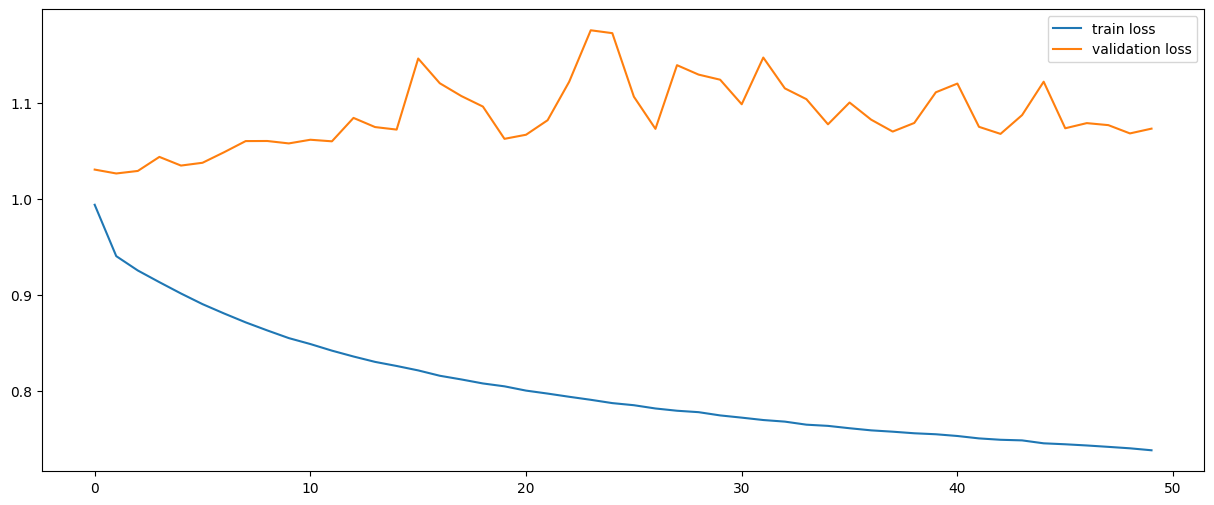

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

# Model Testing

In [ ]:
model = torch.load('best_val_model_pytorch')

n_correct = 0.
n_total = 0.
for inputs, targets in val_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

Test acc: 0.5058


In [ ]:
batch_size=64
test_data=np.expand_dims(np.load('/content/Test/content/2023/11-12_2023_BTCUSDT_1m_DATA.npy'), axis=1)
test_lbls=np.load('/content/Test/content/2023/11-12_2023_BTCUSDT_1m_LBLS.npy')
test_loader = DataLoader(TensorDataset(torch.tensor(test_data[:test_lbls.shape[0]],dtype=torch.float32),
                                    torch.tensor(test_lbls, dtype=torch.float32)),
                                    batch_size=batch_size, shuffle=False) #drop_last=True)

In [ ]:
model = torch.load('best_val_model_pytorch')

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

In [ ]:
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)
all_predictions = np.concatenate(all_predictions)

In [ ]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))